In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
plt.rcParams['figure.figsize'] = [15, 10]

# Задание 1

Напишите функции read_gff и read_bed6 для чтения соответствующих форматов. Они должны возвращать датафреймы как в примере (картинка Example1), но имена колонок можно сделать любыми.

In [75]:
def read_gff(file):
    gff = pd.read_table(file, sep='\t', skiprows=1, names=['chromosome', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
    return gff

gff = read_gff('/home/emulciber/IB/python/Python_BI_2022/homework_5_pandas/rrna_annotation.gff')
gff.head()

,chromosome,source,type,start,end,score,strand,phase,attributes
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,Name=16S_rRNA;product=16S ribosomal RNA
1,Reference_10,barrnap:0.9,rRNA,68981,72061,0.0,+,.,Name=23S_rRNA;product=23S ribosomal RNA
2,Reference_10,barrnap:0.9,rRNA,469298,470826,0.0,+,.,Name=16S_rRNA;product=16S ribosomal RNA
3,Reference_10,barrnap:0.9,rRNA,471166,474246,0.0,+,.,Name=23S_rRNA;product=23S ribosomal RNA
4,Reference_10,barrnap:0.9,rRNA,3629599,3632680,0.0,-,.,Name=23S_rRNA;product=23S ribosomal RNA


In [76]:
def read_bed6(file):
    bed = pd.read_table(file, sep='\t', names=['chromosome', 'start', 'end', 'name', 'score', 'strand'])
    return bed

bed = read_bed6('/home/emulciber/IB/python/Python_BI_2022/homework_5_pandas/alignment.bed')
bed.head()

,chromosome,start,end,name,score,strand
0,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-
1,Reference_1,202886,202996,NODE_19543_length_110_cov_1549.290909,0,-
2,Reference_1,202941,203377,NODE_5666_length_436_cov_418.653543,16,+
3,Reference_1,203322,785222,NODE_25_length_581906_cov_146.024228,60,+
4,Reference_1,785169,1763981,NODE_11_length_978812_cov_132.517515,60,-


Колонка с атрибутами несёт слишком много избыточной информации и ей не удобно пользоваться, оставьте в ней только данные о типе рРНК одной короткой строкой (16S, 23S, 5S).

In [77]:
gff['attributes'] = gff['attributes'].str.extract(r'(\d+S)')

In [78]:
gff.head()

,chromosome,source,type,start,end,score,strand,phase,attributes
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S
1,Reference_10,barrnap:0.9,rRNA,68981,72061,0.0,+,.,23S
2,Reference_10,barrnap:0.9,rRNA,469298,470826,0.0,+,.,16S
3,Reference_10,barrnap:0.9,rRNA,471166,474246,0.0,+,.,23S
4,Reference_10,barrnap:0.9,rRNA,3629599,3632680,0.0,-,.,23S


In [79]:
gff['attributes'].unique()

array(['16S', '23S', '5S'], dtype=object)

Сделайте таблицу, где для каждой хромосомы (на самом деле это не хромосомы, а референсные геномы) показано количество рРНК каждого типа. Постройте barplot, отображающий эти данные (картинка rRNA_barplot)

In [93]:
rrna_types = gff[['chromosome', 'attributes']].value_counts().to_frame().reset_index('chromosome').reset_index('attributes')
rrna_types = rrna_types.rename(columns={0: 'count'})

rrna_types['sort_att'] = rrna_types['attributes'].str.extract('(\d+)').astype(int)
rrna_types['sort_ch'] = rrna_types['chromosome'].str.extract('(\d+)').astype(int)
rrna_types = rrna_types.sort_values(by=['sort_ch', 'sort_att'], ignore_index=True)
rrna_types = rrna_types.drop(['sort_att', 'sort_ch'], axis=1)

rrna_types.head()

,attributes,chromosome,count
0,5S,Reference_1,2
1,16S,Reference_1,2
2,23S,Reference_1,2
3,5S,Reference_2,5
4,16S,Reference_2,5


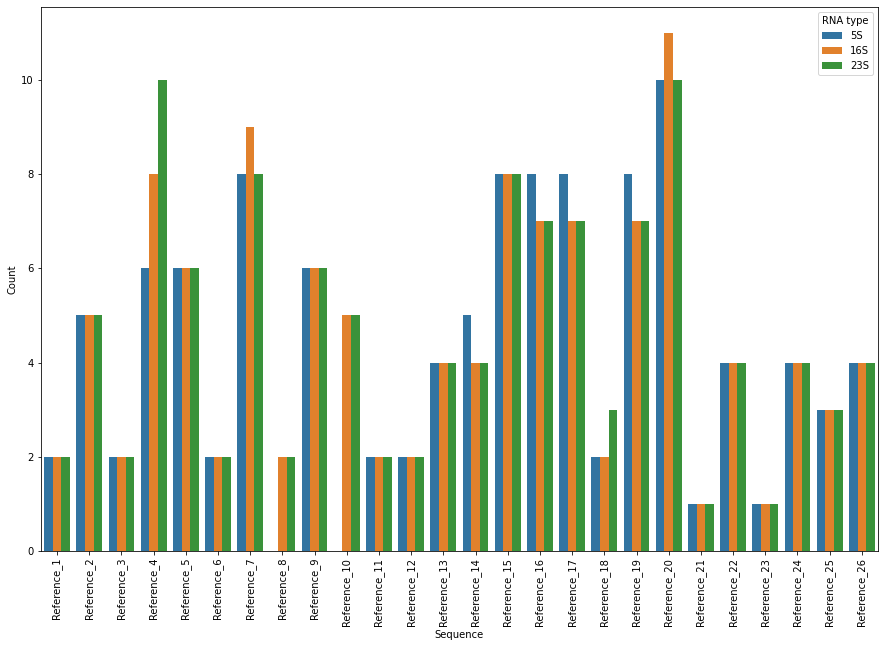

In [95]:
fig1 = sns.barplot(rrna_types, x = 'chromosome', y = 'count', hue='attributes')
fig1.set(xlabel='Sequence', ylabel='Count')
fig1.legend(title='RNA type')
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)
plt.show()

Далее самое интересное. Мы хотим узнать сколько рРНК в процессе сборки успешно собралось. Для этого можно воспользоваться программой bedtools intersect и пересечь эти два файла. В результате сохранятся только записи об рРНК, интервал которой перекрывался с интервалом контига в выравнивании, это означает, что это ген есть в сборке. Но забудьте про bedtools! У нас тут вообще-то пандас! Поэтому давайте получим такой же результат в нём. Выведите таблицу, содержащую исходные записи об рРНК полностью вошедших в сборку (не фрагментом), а также запись о контиге в который эта РНК попала. Итоговая таблица должна выглядеть примерно так (картинка Example2). Обратите внимание, что в один контиг может попасть несколько рРНК.

In [102]:
bed['end'].dtype

dtype('int64')

In [112]:
bed['interval'] = bed[['start', 'end']].apply(lambda x: pd.Interval(x['start'], x['end'], closed='left'), axis=1)
bed

,chromosome,start,end,name,score,strand,interval
0,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,"[197681, 200286)"
1,Reference_1,202886,202996,NODE_19543_length_110_cov_1549.290909,0,-,"[202886, 202996)"
2,Reference_1,202941,203377,NODE_5666_length_436_cov_418.653543,16,+,"[202941, 203377)"
3,Reference_1,203322,785222,NODE_25_length_581906_cov_146.024228,60,+,"[203322, 785222)"
4,Reference_1,785169,1763981,NODE_11_length_978812_cov_132.517515,60,-,"[785169, 1763981)"
...,...,...,...,...,...,...,...
7705,Reference_26,5532432,5535601,NODE_1329_length_3169_cov_103.935132,5,+,"[5532432, 5535601)"
7706,Reference_26,5535546,5535722,NODE_19238_length_176_cov_67.305785,0,+,"[5535546, 5535722)"
7707,Reference_26,5535667,5537226,NODE_2001_length_1559_cov_98.029920,0,+,"[5535667, 5537226)"
7708,Reference_26,5537171,5537343,NODE_19245_length_172_cov_84.367521,0,+,"[5537171, 5537343)"


In [111]:
bed[['start', 'end']].apply(lambda x: pd.Interval(x['start'], x['end'], closed='left'), axis=1)

0         [197681, 200286)
1         [202886, 202996)
2         [202941, 203377)
3         [203322, 785222)
4        [785169, 1763981)
               ...        
7705    [5532432, 5535601)
7706    [5535546, 5535722)
7707    [5535667, 5537226)
7708    [5537171, 5537343)
7709    [5537288, 5608040)
Length: 7710, dtype: interval